In [11]:
# Imports
import numpy as np

from pandas import read_csv 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, explained_variance_score

import matplotlib.pyplot as plt

In [12]:
#  Load dataset and create train-test sets
data = read_csv('data/hairdryer.csv')

In [13]:
var_names = data.columns[0:-1]

<Axes: >

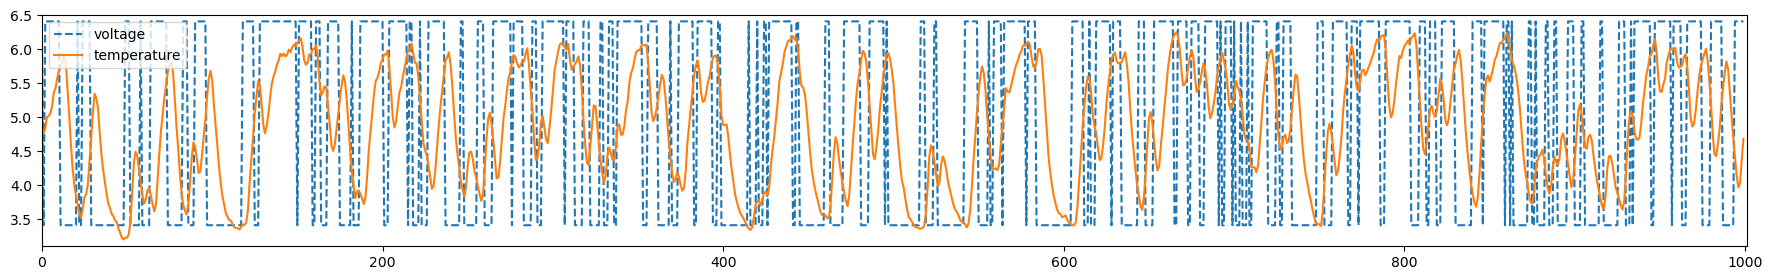

In [14]:
data.plot(figsize=(22,3) , xlim=(0,1001) , ylim=(3.1 , 6.5) , style=['--','-'])

<Axes: >

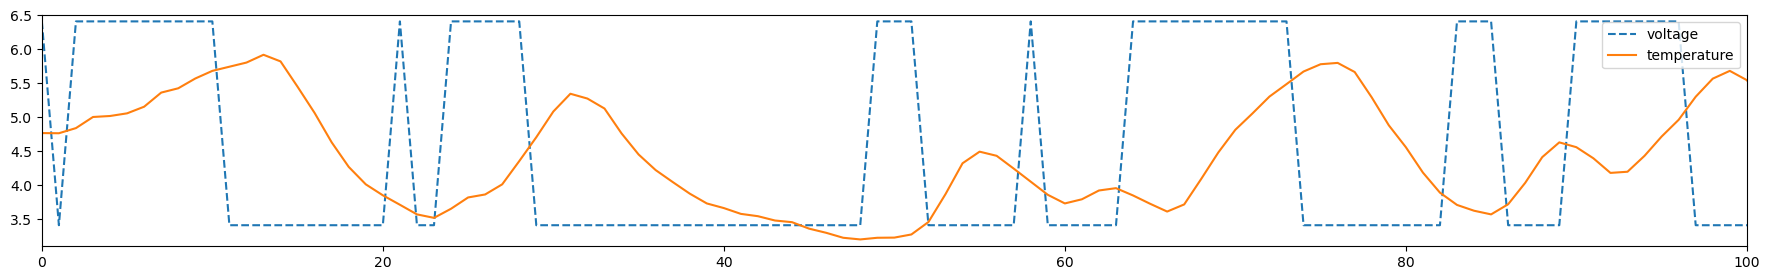

In [15]:
data.plot(figsize=(22,3) , xlim=(0,100) , ylim=(3.1 , 6.5) , style=['--','-'])

In [16]:
data = data.to_numpy()

(3.1, 6.5)

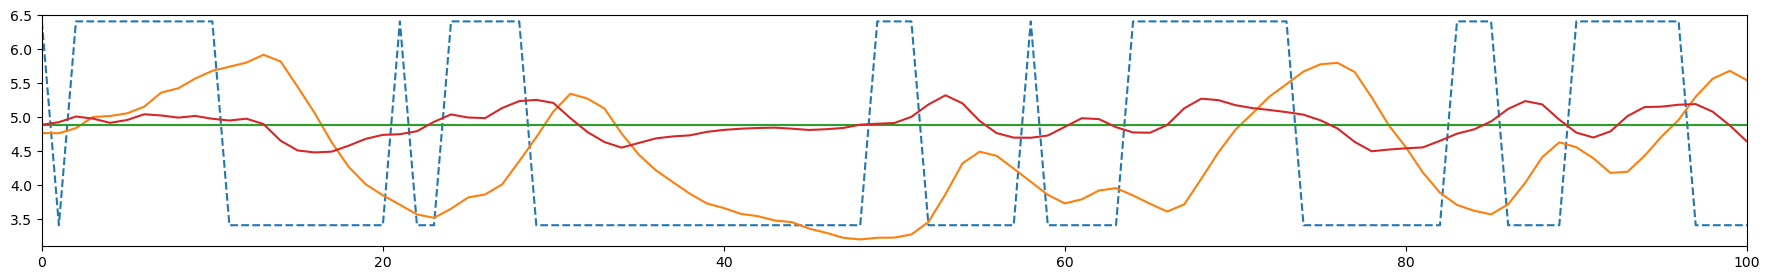

In [17]:
x_grad= np.arange(data[:,1].size)
temp_mean=np.mean(data[:,1])

plt.figure(figsize=(22, 3))  # Set figure size

plt.plot( x_grad ,data[:,0] , '--')
plt.plot( x_grad ,data[:,1] ,'-')
plt.plot( [0,1000], [temp_mean,temp_mean])
plt.plot( x_grad, np.gradient(data[:,1], x_grad)+temp_mean)

plt.xlim(0,100) 
plt.ylim(3.1 , 6.5)


In [18]:
%%script echo skipping

# Run this cell to normalize variables
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

Couldn't find program: 'echo'


# Comparing settings

Fazer gráfico train error vs test error 

 * Detected 2 rules / clusters
 * Detected Sugeno model type
 * Detected 3 rules / clusters
 * Detected Sugeno model type
 * Detected 4 rules / clusters
 * Detected Sugeno model type
 * Detected 5 rules / clusters
 * Detected Sugeno model type
 * Detected 6 rules / clusters
 * Detected Sugeno model type
 * Detected 7 rules / clusters
 * Detected Sugeno model type
 * Detected 8 rules / clusters
 * Detected Sugeno model type
 * Detected 9 rules / clusters
 * Detected Sugeno model type
 * Detected 10 rules / clusters
 * Detected Sugeno model type
 * Detected 2 rules / clusters
 * Detected Sugeno model type
 * Detected 3 rules / clusters
 * Detected Sugeno model type
 * Detected 4 rules / clusters
 * Detected Sugeno model type
 * Detected 5 rules / clusters
 * Detected Sugeno model type
 * Detected 6 rules / clusters
 * Detected Sugeno model type
 * Detected 7 rules / clusters
 * Detected Sugeno model type
 * Detected 8 rules / clusters
 * Detected Sugeno model type
 * Detected 9 rules / c

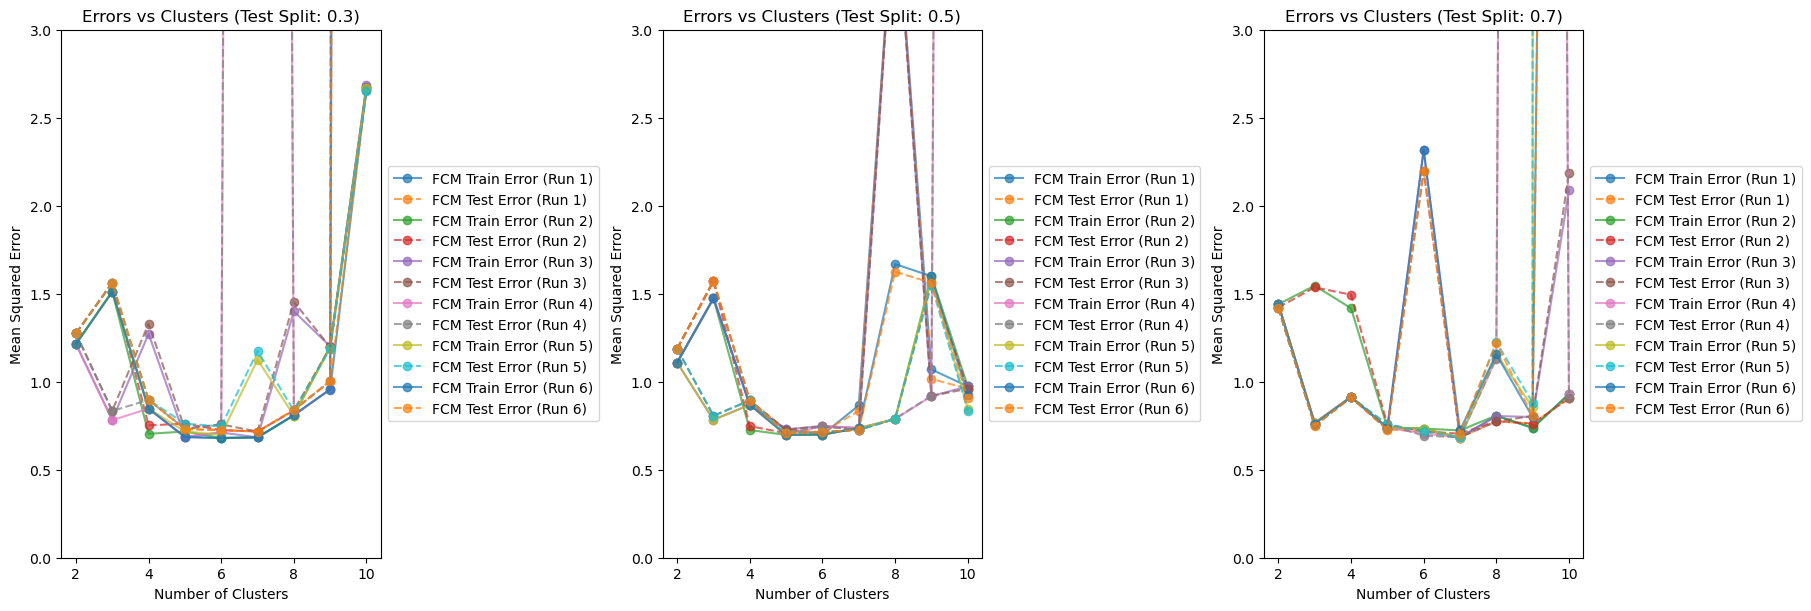

In [19]:
# Define the test split sizes
test_split_sizes = [0.3, 0.5, 0.7]
num_iterations = 6  # Number of times to fit the model for each test split size

# Create a figure with subplots side by side (1 row, 3 columns)
fig, axs = plt.subplots(1, len(test_split_sizes), figsize=(18, 6), constrained_layout=True)

# Loop over different test split sizes
for idx, split_size in enumerate(test_split_sizes):
    ax = axs[idx]  # Select the current subplot

    # Lists to store errors for multiple iterations
    all_fcm_train_errors = []
    all_fcm_test_errors = []
    all_gk_train_errors = []
    all_gk_test_errors = []

    # Run multiple iterations for the same test split size
    for iteration in range(num_iterations):
        # Train/test split
        X = data[:, 0:-1]
        y = data[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=314 )

        # Lists to store errors for each method
        fcm_train_errors = []
        fcm_test_errors = []
        gk_train_errors = []
        gk_test_errors = []

        ncl = np.arange(2, 11)
        mtd = ['fcm']#, 'gk']

        # Capture training and test errors
        for mth in mtd:
            train_errors = []
            test_errors = []
            
            for n in ncl:
                # Clustering
                cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=n)
                clust_centers, part_matrix, _ = cl.cluster(method=mth)

                # Estimate membership functions parameters
                ae = AntecedentEstimator(X_train, part_matrix)
                antecedent_params = ae.determineMF()

                # Estimate consequent parameters
                ce = ConsequentEstimator(X_train, y_train, part_matrix)
                conseq_params = ce.suglms(global_fit=True)  # Using global_fit as an example

                # Build the first-order Takagi-Sugeno model
                modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=False)
                model = modbuilder.get_model()

                # Predictions on training data
                modtester_train = SugenoFISTester(model, X_train, var_names)
                y_train_pred = modtester_train.predict()[0]
                
                # Predictions on test data
                modtester_test = SugenoFISTester(model, X_test, var_names)
                y_test_pred = modtester_test.predict()[0]

                # Compute training and test errors
                train_mse = mean_squared_error(y_train, y_train_pred)
                test_mse = mean_squared_error(y_test, y_test_pred)

                # Store errors for the current method and cluster count
                train_errors.append(train_mse)
                test_errors.append(test_mse)

            # Store the results for each method separately
            if mth == 'fcm':
                fcm_train_errors = train_errors
                fcm_test_errors = test_errors
            elif mth == 'gk':
                gk_train_errors = train_errors
                gk_test_errors = test_errors

        # Store errors for this iteration
        all_fcm_train_errors.append(fcm_train_errors)
        all_fcm_test_errors.append(fcm_test_errors)
        all_gk_train_errors.append(gk_train_errors)
        all_gk_test_errors.append(gk_test_errors)

        # Plotting the errors for this iteration
        ax.plot(ncl, fcm_train_errors, 'o-', label=f'FCM Train Error (Run {iteration+1})', alpha=0.7)
        ax.plot(ncl, fcm_test_errors, 'o--', label=f'FCM Test Error (Run {iteration+1})', alpha=0.7)


    # Title and axis labels for the current subplot
    ax.set_title(f'Errors vs Clusters (Test Split: {split_size})')
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(0, 3)

    # Place the legend outside the plot area
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the final plot
plt.show()


fazer gráfico com actual vs predicted values

In [20]:
%%script echo skipping

### Plot the actual values vs the predicted values of the test data using the matplotlib library

# this is done already on the cell above 
""""# Predict the labels of the test data
pred = model.predict_test_data()"""


"""# Get the actual labels of the test data
_, actual = modbuilder.get_data(data_set='test')
"""

# Create scatterplot
import matplotlib.pyplot as plt 
plt.scatter(y_test, y_pred)
plt.xlabel('Actual value') 
plt.ylabel('Predicted value')
#plt.plot([0,85],[0,85],'r')     # Add a reference line
plt.show()

Couldn't find program: 'echo'


usar K-fold CV para obter performance de cada modelo (modelos com diferentes numeros de clusters)